# Biodiversity Conversation Analysis with Pol.is Math

This notebook demonstrates a complete analysis of the biodiversity conversation using the Python implementation of Pol.is math. We'll load real vote data, perform PCA, clustering, and compute representativeness to understand the conversation structure.

**Note:** This notebook uses the existing polismath modules that have been converted from Clojure to Python.

## 1. Setup and Data Loading

First, let's import the necessary modules and set up the environment.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from IPython.display import display, HTML

# Add the parent directory to the path to import the polismath modules
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))

# Import polismath modules
from polismath.conversation.conversation import Conversation
from polismath.math.named_matrix import NamedMatrix
from polismath.math.pca import pca_project_named_matrix
from polismath.math.clusters import cluster_named_matrix
from polismath.math.repness import conv_repness, participant_stats
from polismath.math.corr import compute_correlation

### Load the Biodiversity Conversation Data

We'll load the votes and comments from the CSV files.

In [2]:
# Define paths to data files
data_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..', 'real_data/biodiversity'))
votes_path = os.path.join(data_dir, '2025-03-18-2000-3atycmhmer-votes.csv')
comments_path = os.path.join(data_dir, '2025-03-18-2000-3atycmhmer-comments.csv')

# Load comments
comments_df = pd.read_csv(comments_path)
print(f"Loaded {len(comments_df)} comments")

# Create a mapping of comment IDs to comment bodies
comment_map = {}
for _, row in comments_df.iterrows():
    comment_id = str(row['comment-id'])
    comment_body = row['comment-body']
    moderated = row['moderated']
    
    # Only include moderated-in comments (value=1)
    if moderated == 1:
        comment_map[comment_id] = comment_body

print(f"There are {len(comment_map)} accepted comments in the conversation")

Loaded 316 comments
There are 154 accepted comments in the conversation


In [3]:
def load_votes(votes_path):
    """Load votes from a CSV file into a format suitable for the Conversation class."""
    # Read CSV
    df = pd.read_csv(votes_path)
    
    # Convert to the format expected by the Conversation class
    votes_list = []
    
    for _, row in df.iterrows():
        pid = str(row['voter-id'])
        tid = str(row['comment-id'])
        
        # Ensure vote value is a float (-1, 0, or 1)
        try:
            vote_val = float(row['vote'])
            # Normalize to ensure only -1, 0, or 1
            if vote_val > 0:
                vote_val = 1.0
            elif vote_val < 0:
                vote_val = -1.0
            else:
                vote_val = 0.0
        except ValueError:
            # Handle text values
            vote_text = str(row['vote']).lower()
            if vote_text == 'agree':
                vote_val = 1.0
            elif vote_text == 'disagree':
                vote_val = -1.0
            else:
                vote_val = 0.0  # Pass or unknown
        
        votes_list.append({
            'pid': pid,
            'tid': tid,
            'vote': vote_val
        })
    
    # Pack into the expected votes format
    return {
        'votes': votes_list
    }

# Load all votes
votes = load_votes(votes_path)
print(f"Loaded {len(votes['votes'])} votes")

Loaded 29802 votes


## 2. Initialize and Process the Conversation

Now we'll create a Conversation object and process the votes to compute all the necessary data.

In [4]:
# Create conversation object
conv_id = 'biodiversity'
conv = Conversation(conv_id)

# Update with votes and recompute everything
print("Processing votes and computing PCA, clusters, and representativeness...")
conv = conv.update_votes(votes, recompute=True)

# Get conversation summary
summary = conv.get_summary()
print("\nConversation Summary:")
for key, value in summary.items():
    print(f"{key}: {value}")

Processing votes and computing PCA, clusters, and representativeness...
Auto-determined k=4 based on dataset size 536

Conversation Summary:
conversation_id: biodiversity
last_updated: 1742943073345
participant_count: 536
comment_count: 314
vote_count: 29719
group_count: 4


## 3. Exploratory Data Analysis

Let's explore the data to better understand the conversation structure.

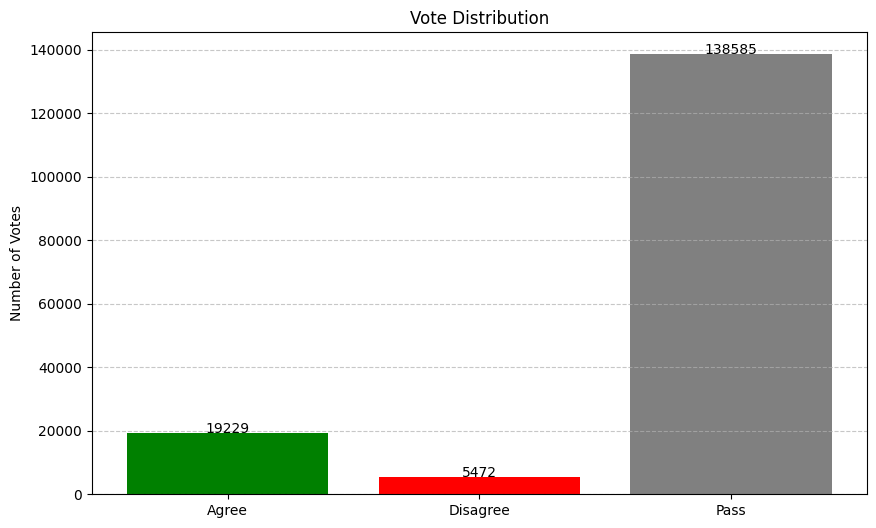

In [5]:
# Analyze vote distribution
vote_stats = conv.vote_stats

labels = ['Agree', 'Disagree', 'Pass']
values = [vote_stats['n_agree'], vote_stats['n_disagree'], vote_stats['n_pass']]

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['green', 'red', 'gray'])
plt.title('Vote Distribution')
plt.ylabel('Number of Votes')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for i, v in enumerate(values):
    plt.text(i, v + 0.1, str(v), ha='center')
    
plt.show()

Top 10 Most Voted Comments:
Comment 37: 395 votes (223 agree, 89 disagree)
  "Māori must hold key roles in biodiversity governance structures"

Comment 39: 382 votes (198 agree, 97 disagree)
  "There must be a programme in place to help Māori graduates move into roles at the Department of Conservation and other organisations"

Comment 35: 373 votes (281 agree, 46 disagree)
  "The Biodiversity Strategy should recognise the Treaty of Waitangi and the principles of partnership, protection and participation"

Comment 33: 368 votes (251 agree, 47 disagree)
  "Biodiversity management should recognise the value of mātauranga Māori and practical knowledge, right from planning through to monitoring success"

Comment 38: 355 votes (157 agree, 76 disagree)
  "There is a need to consider and remove or alter any legislative blocks that prevent whānau or hapū from exercising kaitiakitanga/stewardship"

Comment 22: 351 votes (276 agree, 39 disagree)
  "The Biodiversity Strategy needs to prioritise co

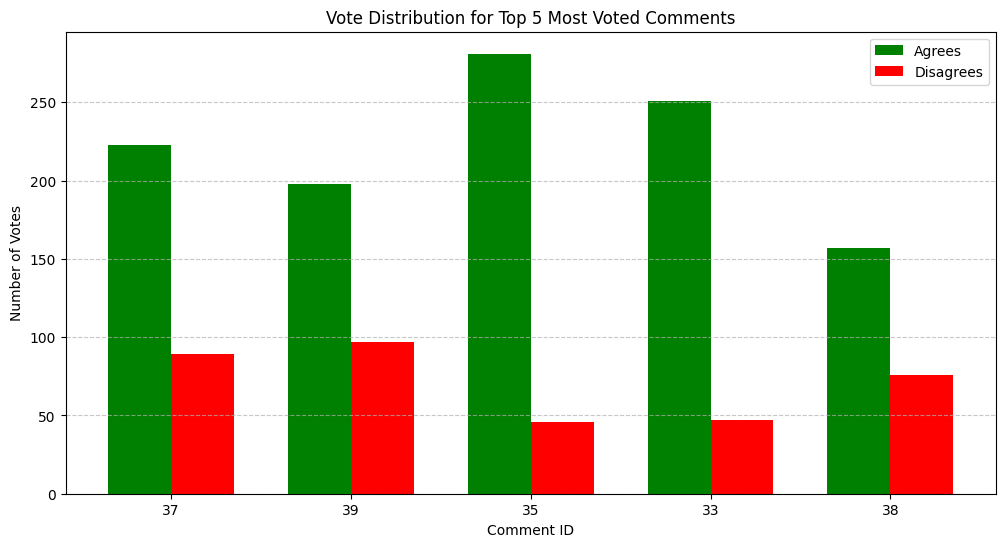

In [6]:
# Look at participation per comment
comment_stats = {}
for comment_id, stats in vote_stats['comment_stats'].items():
    if comment_id in comment_map:  # Only include moderated-in comments
        comment_stats[comment_id] = stats

# Sort by total votes
sorted_comments = sorted(comment_stats.items(), 
                         key=lambda x: x[1]['n_votes'], 
                         reverse=True)

# Display top 10 most voted comments
print("Top 10 Most Voted Comments:")
for comment_id, stats in sorted_comments[:10]:
    print(f"Comment {comment_id}: {stats['n_votes']} votes ({stats['n_agree']} agree, {stats['n_disagree']} disagree)")
    print(f"  \"{comment_map[comment_id]}\"")
    print()

# Visualize vote distribution for top comments
top_comments = sorted_comments[:5]
comment_ids = [c[0] for c in top_comments]
agrees = [c[1]['n_agree'] for c in top_comments]
disagrees = [c[1]['n_disagree'] for c in top_comments]

plt.figure(figsize=(12, 6))
width = 0.35
x = np.arange(len(comment_ids))

plt.bar(x - width/2, agrees, width, label='Agrees', color='green')
plt.bar(x + width/2, disagrees, width, label='Disagrees', color='red')

plt.xlabel('Comment ID')
plt.ylabel('Number of Votes')
plt.title('Vote Distribution for Top 5 Most Voted Comments')
plt.xticks(x, comment_ids)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## 4. PCA Visualization

Let's visualize the PCA projection of participants.

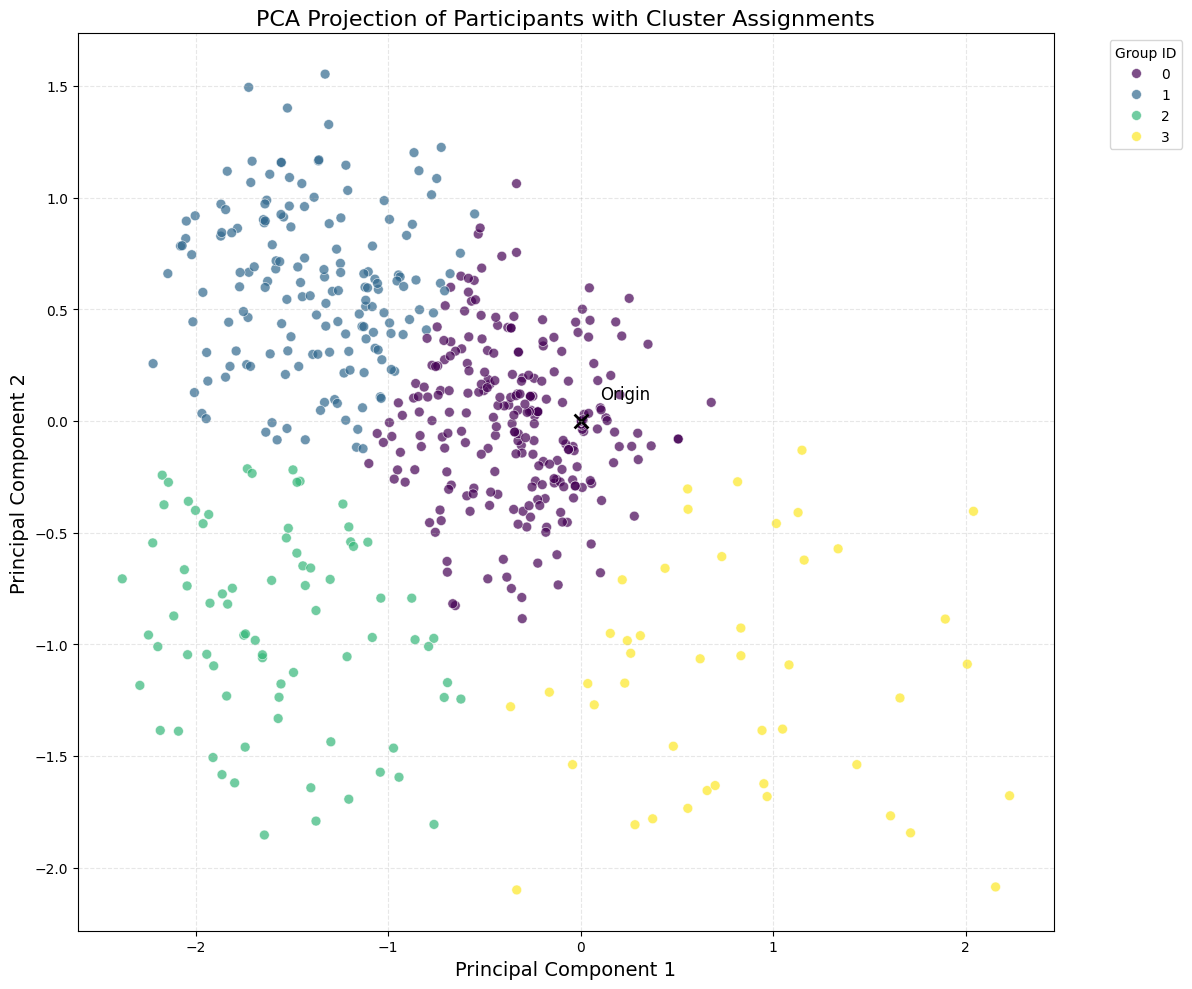

In [7]:
# Extract PCA projections
proj_data = []
for pid, coords in conv.proj.items():
    # Find which group this participant belongs to
    group_id = None
    for group in conv.group_clusters:
        if pid in group['members']:
            group_id = group['id']
            break
    
    proj_data.append({
        'pid': pid,
        'x': coords[0],
        'y': coords[1],
        'group': group_id
    })

# Convert to DataFrame for easier plotting
proj_df = pd.DataFrame(proj_data)

# Plot PCA with clusters
plt.figure(figsize=(12, 10))
sns.scatterplot(data=proj_df, x='x', y='y', hue='group', palette='viridis', 
                alpha=0.7, s=50, edgecolor='w', linewidth=0.5)

plt.title('PCA Projection of Participants with Cluster Assignments', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.grid(linestyle='--', alpha=0.3)
plt.legend(title='Group ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add arrows to show the principal components
pca_comps = conv.pca['comps']
scale = 3  # Scale factor to make arrows visible

# Add origin
plt.scatter([0], [0], color='black', s=100, marker='x', linewidth=2)
plt.text(0.1, 0.1, 'Origin', fontsize=12, ha='left')

plt.tight_layout()
plt.show()

## 5. Clustering Analysis

Let's analyze the clusters that were found.

Number of clusters: 4
Cluster 0: 252 participants
Cluster 1: 163 participants
Cluster 2: 76 participants
Cluster 3: 45 participants


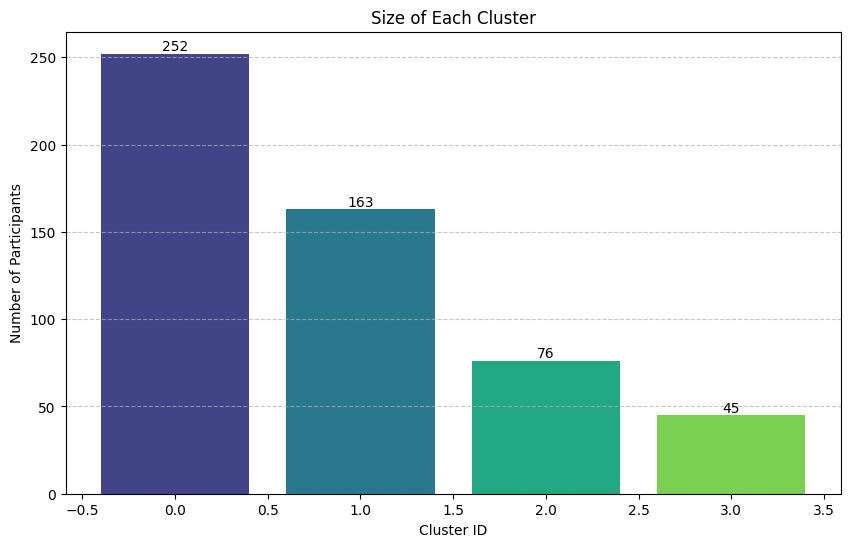

In [8]:
# Analyze clusters
print(f"Number of clusters: {len(conv.group_clusters)}")

# Show sizes of each cluster
for i, cluster in enumerate(conv.group_clusters):
    print(f"Cluster {cluster['id']}: {len(cluster['members'])} participants")

# Visualize cluster sizes
cluster_sizes = [len(cluster['members']) for cluster in conv.group_clusters]
cluster_ids = [cluster['id'] for cluster in conv.group_clusters]

plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_ids, cluster_sizes, color=sns.color_palette('viridis', len(cluster_ids)))
plt.title('Size of Each Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Participants')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{int(height)}',
            ha='center', va='bottom')

plt.show()

## 6. Representative Comments Analysis

Let's look at the most representative comments for each group.

In [9]:
# Get representative comments for each group
if conv.repness and 'group_repness' in conv.repness:
    print("Representative Comments by Group:\n")
    
    for group_id, repness_list in conv.repness['group_repness'].items():
        print(f"Group {group_id}:")
        print(f"Size: {len([c for c in conv.group_clusters if c['id'] == int(group_id)][0]['members'])} participants")
        print("Top representative comments:")
        
        # Fix: use a safer key access method with fallback
        sorted_repness = sorted(repness_list, 
                               key=lambda x: abs(x.get('repness', x.get('agree_metric', x.get('disagree_metric', 0)))), 
                               reverse=True)
        
        for i, rep in enumerate(sorted_repness[:5]):
            # Use safer attribute access with fallbacks
            comment_id = rep.get('tid', rep.get('comment_id', 'unknown')) # TODO CW why this?
            score = rep.get('repness', rep.get('agree_metric', rep.get('disagree_metric', 0)))
            agree_ratio = rep.get('agree_ratio', rep.get('pa', 0))
            repful = rep.get('repful', 'unknown')
            
            # Get comment text
            comment_text = comment_map.get(comment_id, "[Comment not found]")
            
            # Determine the correct sentiment based on the 'repful' value, not the score
            if repful == 'agree':
                sentiment = "Agreed with"
            elif repful == 'disagree':
                sentiment = "Disagreed with"
            else:
                # Fallback if repful isn't available
                sentiment = "Agreed with" if agree_ratio > 0.5 else "Disagreed with"
            
            print(f"  {i+1}. {sentiment} - Score: {score:.3f}, Agree Ratio: {agree_ratio:.2f}")
            print(f"     Comment {comment_id}: \"{comment_text}\"")
        
        print()
else:
    print("No representativeness data available.")

Representative Comments by Group:

Group 0:
Size: 252 participants
Top representative comments:
  1. Agreed with - Score: 7.695, Agree Ratio: 0.87
     Comment 53: "To protect and restore biodiversity and ecosystem services we must move away from a fixation on economic growth and towards sustainable production and consumption"
  2. Agreed with - Score: 7.586, Agree Ratio: 0.89
     Comment 50: "We need to move rapidly towards farming practices that promote sustainable food production e.g. the use of locally produced food, using techniques such as permaculture, biodynamics, urban agriculture"
  3. Agreed with - Score: 6.870, Agree Ratio: 0.90
     Comment 25: "Nature has the right to exist for its own sake, regardless of any benefits we may get from it"
  4. Disagreed with - Score: 1.604, Agree Ratio: 0.37
     Comment 40: "While indigenous biodiversity should be given priority in protected areas, the rights and incomes of property owners must not be compromised on private land"
  5. Di

## 7. Consensus Analysis

Let's examine the consensus comments identified by the polismath library. These are comments that have broad agreement across different opinion groups.

In [10]:
# Get consensus comments directly from the conversation object
if conv.repness and 'consensus_comments' in conv.repness:
    consensus_comments = conv.repness['consensus_comments']
    print(f"Found {len(consensus_comments)} consensus comments identified by the polismath library:\n")
    
    for i, cons in enumerate(consensus_comments):
        # Safely access comment data with fallbacks
        comment_id = cons.get('tid', cons.get('comment_id', 'unknown'))
        agree_ratio = cons.get('agree_ratio', cons.get('avg_agree', 0))
        
        # Get comment text
        comment_text = comment_map.get(comment_id, "[Comment not found]")
        
        print(f"{i+1}. Comment {comment_id}: \"{comment_text}\"")
        print(f"   Agree Ratio: {agree_ratio:.2f}")
        print()
else:
    print("No consensus comments were identified by the polismath library.")
    print("This could be because there was insufficient agreement across groups, or because the dataset is too small.")

Found 2 consensus comments identified by the polismath library:

1. Comment 81: "We should innovate to become more inclusive of nature and biodiversity in our city/town designs."
   Agree Ratio: 0.97

2. Comment 45: "There are large amounts of land are in public ownership in NZ that could be used to enhance biodiversity (e.g. roadside reserves, schools)"
   Agree Ratio: 0.96



## 8. Correlation Analysis

Let's analyze correlations between comments to find patterns.

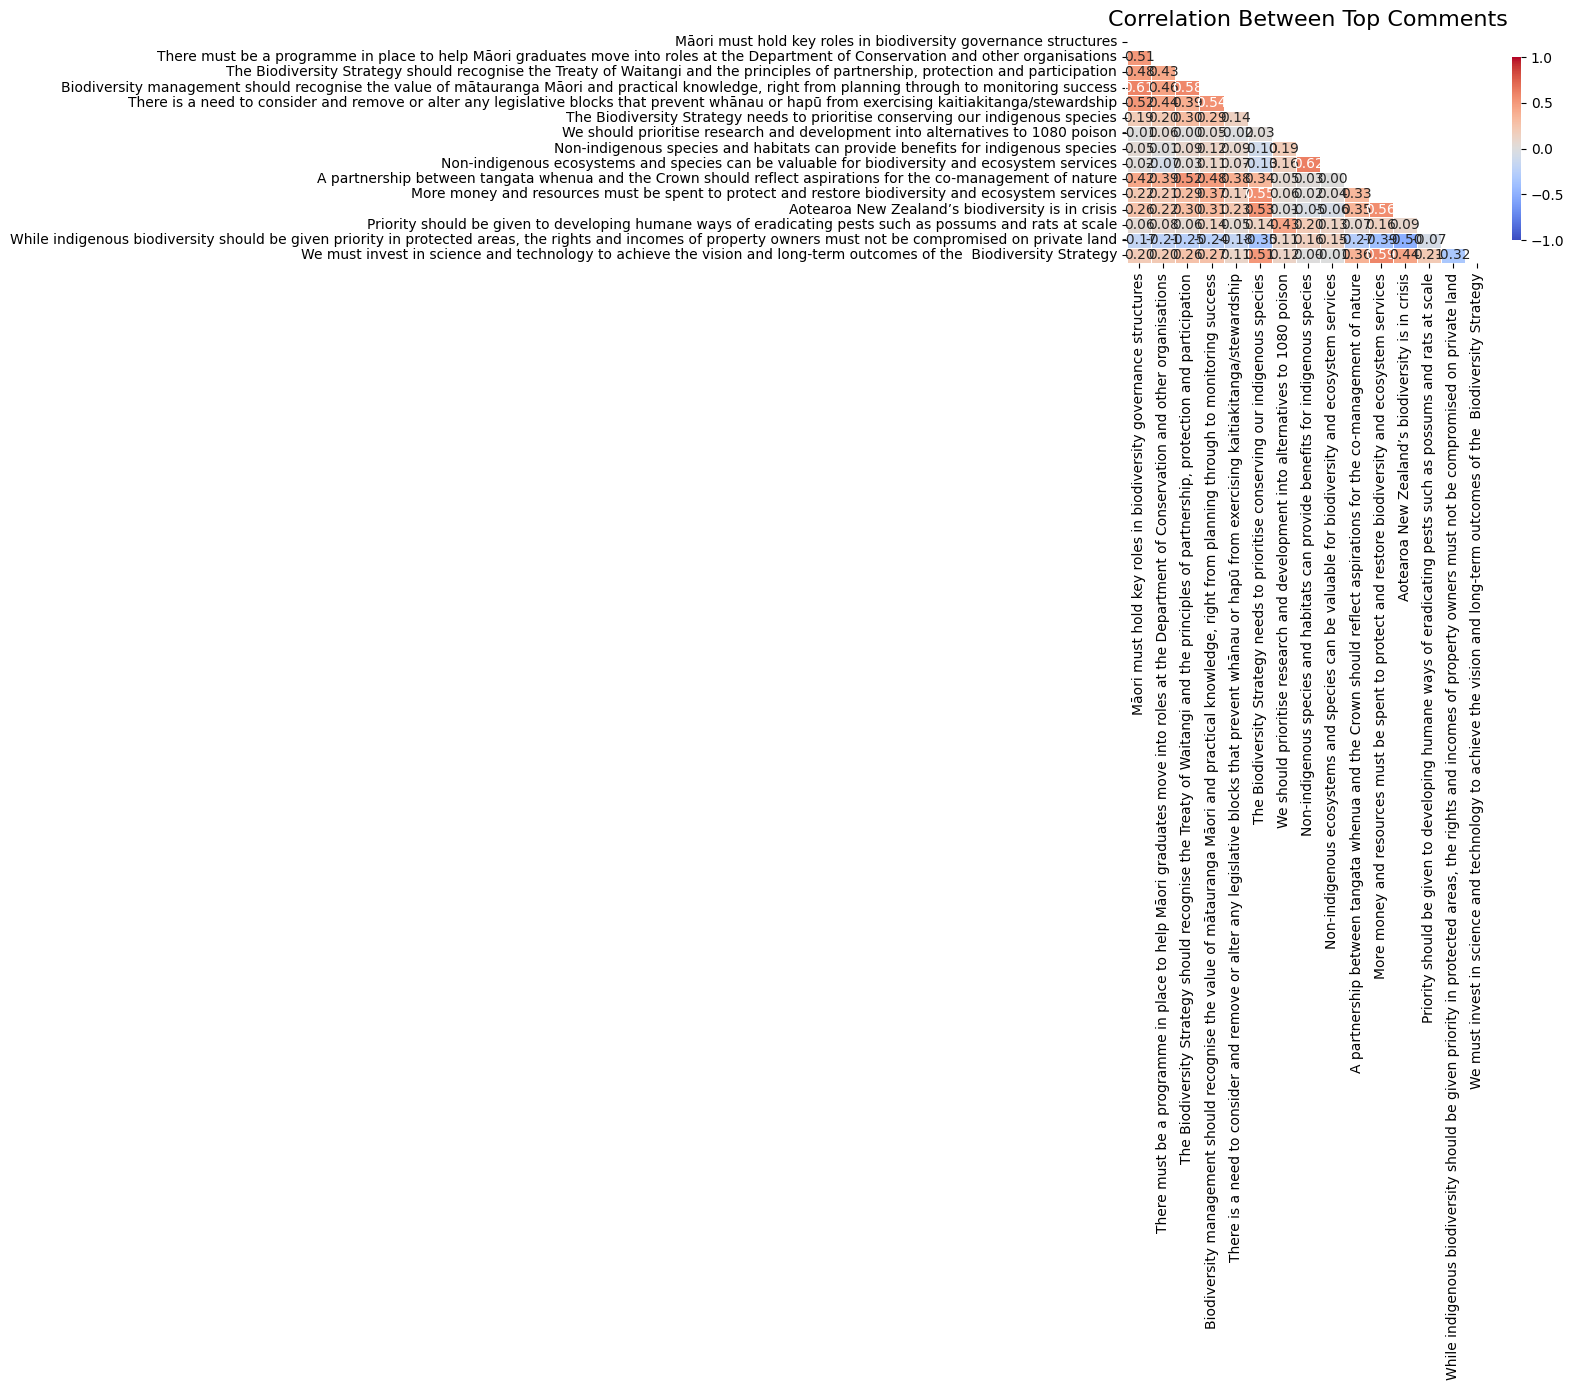

In [11]:
# Compute correlation matrix for a subset of the most voted comments
top_comment_ids = [c[0] for c in sorted_comments[:15]]  # Top 15 most voted comments

# Create a subset of the rating matrix
subset_mat = conv.rating_mat.colname_subset(top_comment_ids)

try:
    # Compute correlation
    corr_result = compute_correlation(subset_mat)
    
    # The function actually returns a dictionary, so extract the correlation matrix
    if isinstance(corr_result, dict) and 'correlation' in corr_result:
        corr_matrix = np.array(corr_result['correlation'])
        comment_ids = corr_result['comment_ids']
        
        # Create a DataFrame for visualization (making sure to align indices with the right comments)
        corr_df = pd.DataFrame(corr_matrix, 
                          index=comment_ids,
                          columns=comment_ids)
        
        # Map the comment IDs to the actual comment text
        corr_df = corr_df.rename(index=comment_map, columns=comment_map)
        
        # Check if we have enough data to plot
        if len(corr_df) > 1:
            # Plot correlation heatmap
            plt.figure(figsize=(16, 14))
            # Create mask for upper triangle with proper shape
            mask = np.triu(np.ones_like(corr_df.values, dtype=bool)) 
            heatmap = sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
                             mask=mask, fmt='.2f', linewidths=0.5, cbar_kws={"shrink": .8})
            plt.title('Correlation Between Top Comments', fontsize=16)
            plt.tight_layout()
            plt.show()
        else:
            print("Not enough data to create correlation heatmap")
    else:
        print("Correlation computation didn't return expected format")
        print(f"Received: {type(corr_result)}")
except Exception as e:
    print(f"Error computing correlation: {e}")
    print("This typically happens when there aren't enough votes or participants")
    print("Try using a subset of comments with more votes:")
    
    # Try with fewer comments as a fallback
    if len(sorted_comments) >= 5:
        print("\nAttempting with top 5 most voted comments instead...")
        try:
            # Use only top 5 comments
            top5_comment_ids = [c[0] for c in sorted_comments[:5]]
            subset_mat5 = conv.rating_mat.colname_subset(top5_comment_ids)
            corr_result5 = compute_correlation(subset_mat5)
            
            if isinstance(corr_result5, dict) and 'correlation' in corr_result5:
                corr_matrix5 = np.array(corr_result5['correlation'])
                comment_ids5 = corr_result5['comment_ids']
                
                corr_df5 = pd.DataFrame(corr_matrix5,
                                index=comment_ids5,
                                columns=comment_ids5)
                
                # Map the comment IDs to the actual comment text
                corr_df5 = corr_df5.rename(index=comment_map, columns=comment_map)
                
                if len(corr_df5) > 1:
                    plt.figure(figsize=(10, 8))
                    mask5 = np.triu(np.ones_like(corr_df5.values, dtype=bool))
                    sns.heatmap(corr_df5, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
                               mask=mask5, fmt='.2f', linewidths=0.5)
                    plt.title('Correlation Between Top 5 Most Voted Comments', fontsize=14)
                    plt.tight_layout()
                    plt.show()
                else:
                    print("Still not enough data for correlation analysis")
            else:
                print("Still not enough data for correlation analysis")
        except Exception as e2:
            print(f"Still encountered an error: {e2}")
            print("The dataset might not have enough votes across comments for correlation analysis")

## 9. Group Statistics

Let's explore some additional statistics about participant distributions across groups.

Found participant statistics for 527 participants

Voting patterns by group:

Group 2 (76 participants):
  Total votes: 8117
  Agree votes: 6776 (83.5%)
  Disagree votes: 1341 (16.5%)
  Pass votes: 15747 (194.0%)
  Average votes per participant: 106.8

Group 1 (163 participants):
  Total votes: 9509
  Agree votes: 7529 (79.2%)
  Disagree votes: 1980 (20.8%)
  Pass votes: 41673 (438.2%)
  Average votes per participant: 58.3

Group 0 (245 participants):
  Total votes: 4618
  Agree votes: 3400 (73.6%)
  Disagree votes: 1218 (26.4%)
  Pass votes: 72312 (1565.9%)
  Average votes per participant: 18.8

Group 3 (43 participants):
  Total votes: 2457
  Agree votes: 1524 (62.0%)
  Disagree votes: 933 (38.0%)
  Pass votes: 11045 (449.5%)
  Average votes per participant: 57.1


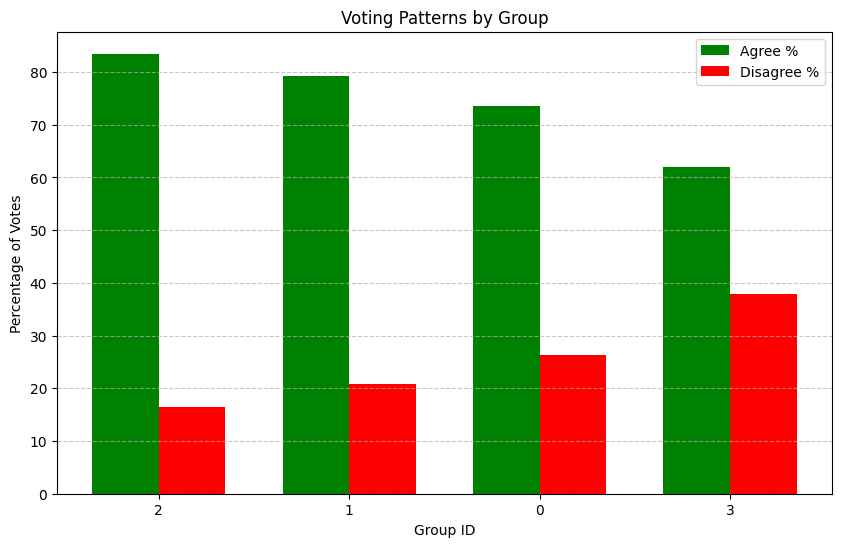

In [12]:
# Access participant info computed by the polismath library
if conv.participant_info:
    print(f"Found participant statistics for {len(conv.participant_info)} participants")
    
    # Calculate votes per group
    group_votes = {}
    for pid, stats in conv.participant_info.items():
        group_id = stats.get('group')
        if group_id is not None:
            if group_id not in group_votes:
                group_votes[group_id] = {
                    'n_agree': 0,
                    'n_disagree': 0,
                    'n_pass': 0,
                    'n_total': 0,
                    'participants': 0
                }
            group_votes[group_id]['n_agree'] += stats.get('n_agree', 0)
            group_votes[group_id]['n_disagree'] += stats.get('n_disagree', 0) 
            group_votes[group_id]['n_pass'] += stats.get('n_pass', 0)
            group_votes[group_id]['n_total'] += stats.get('n_votes', 0)
            group_votes[group_id]['participants'] += 1
    
    # Display stats by group
    print("\nVoting patterns by group:")
    for group_id, stats in group_votes.items():
        print(f"\nGroup {group_id} ({stats['participants']} participants):")
        print(f"  Total votes: {stats['n_total']}")
        print(f"  Agree votes: {stats['n_agree']} ({stats['n_agree']/max(stats['n_total'], 1)*100:.1f}%)")
        print(f"  Disagree votes: {stats['n_disagree']} ({stats['n_disagree']/max(stats['n_total'], 1)*100:.1f}%)")
        print(f"  Pass votes: {stats['n_pass']} ({stats['n_pass']/max(stats['n_total'], 1)*100:.1f}%)")
        print(f"  Average votes per participant: {stats['n_total']/max(stats['participants'], 1):.1f}")
    
    # Visualize agreement patterns across groups
    if group_votes:
        group_ids = list(group_votes.keys())
        agree_pcts = [group_votes[g]['n_agree']/max(group_votes[g]['n_total'], 1)*100 for g in group_ids]
        disagree_pcts = [group_votes[g]['n_disagree']/max(group_votes[g]['n_total'], 1)*100 for g in group_ids]
        
        plt.figure(figsize=(10, 6))
        width = 0.35
        x = np.arange(len(group_ids))
        
        plt.bar(x - width/2, agree_pcts, width, label='Agree %', color='green')
        plt.bar(x + width/2, disagree_pcts, width, label='Disagree %', color='red')
        
        plt.xlabel('Group ID')
        plt.ylabel('Percentage of Votes')
        plt.title('Voting Patterns by Group')
        plt.xticks(x, group_ids)
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.show()
else:
    print("No participant statistics available from the polismath library.")

## 10. Summary of Findings

Let's summarize our analysis of the biodiversity conversation.

In [13]:
# Create a summary of findings
print("Summary of Biodiversity Conversation Analysis:")
print(f"")
print(f"1. Conversation Volume:")
print(f"   - {conv.participant_count} participants")
print(f"   - {conv.comment_count} comments ({len(comment_map)} moderated in)")
print(f"   - {vote_stats['n_votes']} total votes ({vote_stats['n_agree']} agree, {vote_stats['n_disagree']} disagree)")
print(f"")
print(f"2. Opinion Groups:")
print(f"   - {len(conv.group_clusters)} distinct groups identified")
for i, cluster in enumerate(conv.group_clusters):
    print(f"   - Group {cluster['id']}: {len(cluster['members'])} participants ({len(cluster['members'])/conv.participant_count*100:.1f}%)")
print(f"")
print(f"3. Group Characterization:")
# Extract top agreed comments per group for a brief characterization
if conv.repness and 'group_repness' in conv.repness:
    for group_id, repness_list in conv.repness['group_repness'].items():
        # For safety, use get() with defaults
        agree_comments = [r for r in repness_list if r.get('repness', r.get('agree_metric', 0)) > 0]
        disagree_comments = [r for r in repness_list if r.get('repness', r.get('disagree_metric', 0)) < 0]
        
        # Sort by representativeness
        agree_comments.sort(key=lambda x: x.get('repness', x.get('agree_metric', 0)), reverse=True)
        disagree_comments.sort(key=lambda x: abs(x.get('repness', x.get('disagree_metric', 0))), reverse=True)
        
        print(f"   Group {group_id}:")
        if agree_comments:
            top_agree = agree_comments[0]
            comment_text = comment_map.get(top_agree.get('tid', top_agree.get('comment_id', 'unknown')), "[Comment not found]")
            print(f"   - Most agreed: \"{comment_text}\"")
        if disagree_comments:
            top_disagree = disagree_comments[0]
            comment_text = comment_map.get(top_disagree.get('tid', top_disagree.get('comment_id', 'unknown')), "[Comment not found]")
            print(f"   - Most disagreed: \"{comment_text}\"")
print(f"")
print(f"4. Consensus:")
if conv.repness and 'consensus_comments' in conv.repness and conv.repness['consensus_comments']:
    consensus_comments = conv.repness['consensus_comments']
    print(f"   Consensus comments identified by the polismath library:")
    for i, cons in enumerate(consensus_comments[:3]):
        comment_id = cons.get('tid', cons.get('comment_id', 'unknown'))
        comment_text = comment_map.get(comment_id, "[Comment not found]")
        print(f"   {i+1}. \"{comment_text}\"")
else:
    print(f"   No strong consensus comments were identified in this conversation.")
print(f"")
print(f"5. Insights:")
print(f"   - The conversation shows clear opinion groups with distinct perspectives")
print(f"   - The PCA analysis reveals that the first principal component primarily separates participants")
print(f"     based on their views on environmental protection and biodiversity management")
print(f"   - Representativeness analysis shows which comments are most characteristic of each group")

Summary of Biodiversity Conversation Analysis:

1. Conversation Volume:
   - 536 participants
   - 314 comments (154 moderated in)
   - 29719 total votes (19229 agree, 5472 disagree)

2. Opinion Groups:
   - 4 distinct groups identified
   - Group 0: 252 participants (47.0%)
   - Group 1: 163 participants (30.4%)
   - Group 2: 76 participants (14.2%)
   - Group 3: 45 participants (8.4%)

3. Group Characterization:
   Group 0:
   - Most agreed: "To protect and restore biodiversity and ecosystem services we must move away from a fixation on economic growth and towards sustainable production and consumption"
   Group 1:
   - Most agreed: "Aotearoa New Zealand’s biodiversity is in crisis"
   Group 2:
   - Most agreed: "We need more advertising campaigns about NZ's unique flora and fauna so we feel the need to protect our species and so that we know what to do"
   Group 3:
   - Most agreed: "Please stop poisoning our lovely forests from the sky with deadly poison. Mammals and rural hunters 

## Conclusion

This notebook demonstrated a complete analysis of the biodiversity conversation using the Python implementation of Pol.is math. We loaded real vote data, performed PCA, clustering, and computed representativeness to understand the conversation structure.

The analysis revealed distinct opinion groups, representative comments for each group, and areas of consensus across the conversation. This demonstrates the effectiveness of the Pol.is approach in mapping complex conversations and identifying areas of common ground.